# Connect Intensive - Machine Learning Nanodegree
# Lesson 6: PCA Mini Project


## Objectives
  - Perform Principal Component Analysis (PCA) on a large set of features to explain as much of the variance as possible in the data using a smaller set of features (reducing the dimensionality).
  - Introduce the `class_weight` parameter for `SVC()`, to see how correctly predicting targets from a smaller class size can be weighted more heavily.
  - Visualize the eigenfaces (orthonormal basis of components) that result from PCA.
  
## Prerequisites
  - You should have the following python packages installed:
    - [matplotlib](http://matplotlib.org/index.html)
    - [numpy](http://www.scipy.org/scipylib/download.html)
    - [sklearn](http://scikit-learn.org/stable/install.html)
  - For context, you should also have watched Sebastian & Katie's Udacity video lectures on PCA prior to working through this notebook.
    
## Acknowledgements
  - The content of this notebook builds on the code from [pca/eigenfaces.py](https://github.com/udacity/ud120-projects/blob/master/pca/eigenfaces.py) from the [**ud120-projects**](https://github.com/udacity/ud120-projects) repo, and derives from [an eigenfaces/SVM example in the sklearn documentation](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html)
  

## PCA Mini-Project


PCA Mini-Project

Our discussion of PCA spent a lot of time on theoretical issues, so in this mini-project we’ll ask you to play around with some sklearn code. The eigenfaces code is interesting and rich enough to serve as the testbed for this entire mini-project.

The starter code can be found in pca/eigenfaces.py. This was mostly taken from the example found here, on the sklearn documentation.
Take note when running the code, that there are changes in one of the parameters for the SVC function called on line 94 of pca/eigenfaces.py. For the 'class_weight' parameter, the argument string "auto" is a valid value for sklearn version 0.16 and prior, but will be depreciated by 0.19. If you are running sklearn version 0.17 or later, the expected argument string should be "balanced". If you get an error or warning when running pca/eigenfaces.py, make sure that you have the correct argument on line 98 that matches your installed version of sklearn.

In [1]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""

print __doc__

from time import time
import logging
import pylab as pl
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.decomposition import RandomizedPCA: deprecated 
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from IPython.display import display, Image 

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


print "sklearn version: ", sklearn.__version__



Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


sklearn version:  0.18.1


In [2]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print "Total dataset size:"
print "n_samples: %d" % n_samples
print "n_features: %d" % n_features
print "n_classes: %d" % n_classes


2017-03-26 15:33:32,423 Loading LFW people faces from C:\Users\Ryan\scikit_learn_data\lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [3]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 150

print "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
t0 = time()
pca = PCA(svd_solver='randomized',n_components=n_components, whiten=True).fit(X_train)
print "done in %0.3fs" % (time() - t0)

eigenfaces = pca.components_.reshape((n_components, h, w))

print "Projecting the input data on the eigenfaces orthonormal basis"
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print "done in %0.3fs" % (time() - t0)

Extracting the top 150 eigenfaces from 966 faces
done in 0.247s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.025s


In [5]:
###############################################################################
# Train a SVM classification model

print "Fitting the classifier to the training set"
t0 = time()
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print "done in %0.3fs" % (time() - t0)
print "Best estimator found by grid search:"
print clf.best_estimator_

Fitting the classifier to the training set
done in 25.941s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [6]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print "Predicting the people names on the testing set"
t0 = time()
y_pred = clf.predict(X_test_pca)
print "done in %0.3fs" % (time() - t0)

print classification_report(y_test, y_pred, target_names=target_names)
print confusion_matrix(y_test, y_pred, labels=range(n_classes))

Predicting the people names on the testing set
done in 0.072s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.93      0.87      0.90       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.84      0.83      0.83       322

[[  9   0   3   1   0   0   0]
 [  2  52   1   4   0   1   0]
 [  4   0  22   1   0   0   0]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  19   1   2]
 [  0   3   0   1   2   8   1]
 [  0   2   1   2   1   0  30]]


In [7]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())
        
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

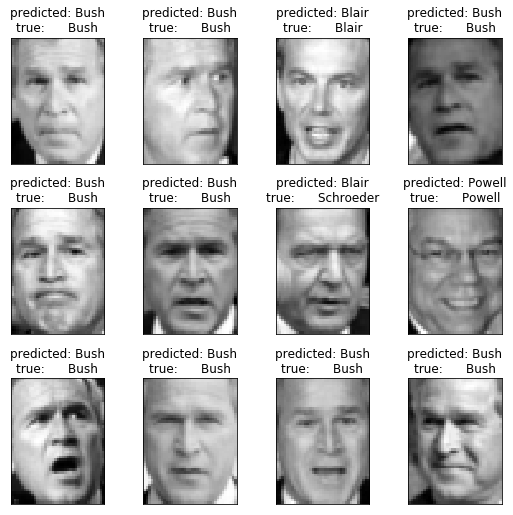

In [8]:
# Predictions

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)
pl.show()

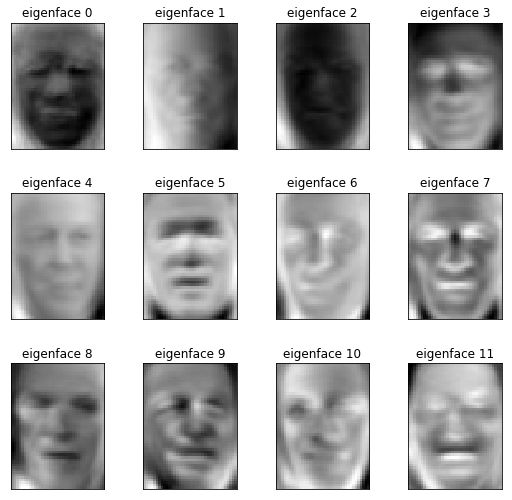

In [9]:
# plot the gallery of the most significant eigenfaces

eigenface_titles = ["eigenface {}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
pl.show()

## Explained Variance of Each PC

We mentioned that PCA will order the principal components, with the first PC giving the direction of maximal variance, second PC has second-largest variance, and so on. 

**How much of the variance is explained by the first principal component? The second**







In [10]:
for eigen, var in enumerate(pca.explained_variance_ratio_[:2]):
    print("Eigenface {} explains {:.2f}% of the variance.".format(eigen+1, var*100.0))
    

Eigenface 1 explains 19.35% of the variance.
Eigenface 2 explains 15.12% of the variance.


Potential Issue 

Quiz: Explained Variance Of Each PC
We found that sometimes the pillow module (which is being used in this example) can cause trouble. If you get an error related to the fetch_lfw_people() command, try the following:

pip install --upgrade PILLOW

If you run into a different error, note that there are changes in one of the parameters for the SVC function called on line 94 of pca/eigenfaces.py. For the 'class_weight' parameter, the argument string "auto" is a valid value for sklearn version 0.16 and prior, but will be depreciated by 0.19. If you are running sklearn version 0.17 or later, the expected argument string should be "balanced". If you get an error or warning when running pca/eigenfaces.py, make sure that you have the correct argument on line 98 that matches your installed version of sklearn.

## How Many PCs to Use?


Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

We’ll learn about the F1 score properly in the lesson on evaluation metrics, but you’ll figure out for yourself whether a good classifier is characterized by a high or low F1 score. You’ll do this by varying the number of principal components and watching how the F1 score changes in response.

**As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?**



- better

- could go either way X

- worse 

- doesn't change 

## F1 Score vs. No. of PCs Used

Change n_components to the following values: [10, 15, 25, 50, 100, 250]. For each number of principal components, note the F1 score for Ariel Sharon. (For 10 PCs, the plotting functions in the code will break, but you should be able to see the F1 scores.) 

**If you see a higher F1 score, does it mean the classifier is doing better, or worse?**


- better x
- worse
- need more information

In [11]:

n_components_list =  [10, 15, 25, 50, 100, 250, 500]

for n_components in n_components_list:

    print "PC #: ", (n_components)
    pca = PCA(svd_solver='randomized',n_components=n_components, whiten=True).fit(X_train)

    eigenfaces = pca.components_.reshape((n_components, h, w))
  
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
   
    param_grid = {
             'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
              }
   
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
    clf = clf.fit(X_train_pca, y_train)
    
    y_pred = clf.predict(X_test_pca)
    print classification_report(y_test, y_pred, target_names=target_names)

PC #:  10
                   precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.43      0.53      0.48        60
  Donald Rumsfeld       0.26      0.33      0.30        27
    George W Bush       0.66      0.58      0.62       146
Gerhard Schroeder       0.17      0.20      0.18        25
      Hugo Chavez       0.25      0.13      0.17        15
       Tony Blair       0.50      0.39      0.44        36

      avg / total       0.49      0.46      0.47       322

PC #:  15
                   precision    recall  f1-score   support

     Ariel Sharon       0.24      0.46      0.32        13
     Colin Powell       0.64      0.72      0.68        60
  Donald Rumsfeld       0.44      0.59      0.51        27
    George W Bush       0.82      0.68      0.74       146
Gerhard Schroeder       0.39      0.44      0.42        25
      Hugo Chavez       0.60      0.40      0.48        15
       Tony Blair       0.50    

## Dimensionality Reduction and Overfitting

**Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?**

- no, more PCs always gives better performance 
- no, more PCs don't change performance 
- need more information 
- yes, performance starts to drop with many PCs x



## Selecting Principal Components


In [12]:
Image('pca_pic.png')

# train different # of PC 